In [1]:
import pandas as pd
import numpy as np
import datetime
import pickle as pkl

import dash
from dash import dcc
from dash import html
from jupyter_dash import JupyterDash
import plotly.express as px


# EIRVA

## Data prep

In [22]:
# construct a time series of fri-fri return and the volatility of such

def log_return(df_close_px, t='', t_1='',  fri_weekly=False):
    if fri_weekly:
        px_t = df_close_px.resample('W-FRI').last()
        px_t_1 = df_close_px.resample('W-FRI').last().shift(1)
    else:
        px_t = df_close_px.loc[t, :]
        px_t_1 = df_close_px.loc[t_1, :]
        
    # For the future: Holidays are not handled here by filling n/a with 0 returns.  
    return np.log(px_t/px_t_1).fillna(0)

load_t = '20220318'
df_5y = pkl.load(open('./data/df_5y_{}.pkl'.format(load_t), 'rb'))

# df_2y = df_5y['Close'].loc[df_5y['Close'].index > (df_5y['Close'].index[-1] - datetime.timedelta(days=2*52*7)), :]
# df_2y_ret = log_return(df_2y, fri_weekly=True)
# df_2y_ret = df_2y_ret.drop(df_2y_ret.index[0], axis=0)

df_5y_ret = log_return(df_5y['Close'], fri_weekly=True)
df_5y_ret = df_5y_ret.drop(df_5y_ret.index[0], axis=0)

# rolling mean return and volatility

# 1y rolling mean weekly returns
df_weekly_return_rolling_1y_mean = df_5y_ret.rolling(52).mean()
df_weekly_return_rolling_1y_mean = df_weekly_return_rolling_1y_mean.loc[~df_weekly_return_rolling_1y_mean.isnull().any(axis=1), :]

# 1y rolling mean weekly vol annualized
df_weekly_return_rolling_1y_volann = df_5y_ret.rolling(52).std() * np.sqrt(52)
df_weekly_return_rolling_1y_volann = df_weekly_return_rolling_1y_volann.loc[~df_weekly_return_rolling_1y_volann.isnull().any(axis=1), :]

df_info_raw=pkl.load(open(f'./data/df_info_raw_{load_t}.pkl', 'rb'))

df_rolling_1y = pd.merge(df_weekly_return_rolling_1y_mean.iloc[-1,:].rename('mean_return'), df_weekly_return_rolling_1y_volann.iloc[-1,:].rename('ann_vol'), left_index=True, right_index=True, how='left')
df_rolling_1y = df_rolling_1y.merge(df_info_raw.loc['shortName'], how='left', left_index=True, right_index=True).reset_index()
df_rolling_1y['ticker_name'] = df_rolling_1y[['index', 'shortName']].astype(str).agg(' '.join, axis=1)

In [71]:
# 3m rolling mean weekly vol annualized
df_weekly_return_rolling_3m_volann = df_5y_ret.rolling(13).std() * np.sqrt(52)
df_weekly_return_rolling_3m_volann = df_weekly_return_rolling_3m_volann.loc[~df_weekly_return_rolling_3m_volann.isnull().any(axis=1), :]


## OLS model

In [ ]:
# Load features matrix from Combination OLS regression
df_X, df_y = pkl.load(open(f'./data/df_X__df_y_{load_t}.pkl', 'rb'))

In [312]:
X = df_X.to_numpy().astype(float)
y = df_y.to_numpy().reshape(-1)

In [314]:
# Need to weigh by coef from model

In [316]:
import statsmodels.api as sm

model_comb = sm.OLS(y, X, hasconst=True).fit()
# model_comb.summary()


In [389]:
model_comb.params.shape

(80,)

In [390]:
df_X.columns.shape

(80,)

In [393]:
# Which factors matter the most?
df_X.columns[np.argsort(-model_comb.params)]

Index(['Medical Distribution', 'Electronic Gaming & Multimedia',
       'Entertainment', 'Tools & Accessories', 'Real Estate—Development',
       'Financial Data & Stock Exchanges', 'Packaging & Containers',
       'Drug Manufacturers—Specialty & Generic',
       'Insurance—Property & Casualty', 'Textile Manufacturing', 'Lodging',
       'Medical Devices', 'Capital Markets', 'priceToSalesTrailing12Months',
       'Auto Parts', 'Insurance—Life', 'Building Products & Equipment',
       'Building Materials', 'debtToEquity',
       'Other Industrial Metals & Mining', 'Auto Manufacturers',
       'Internet Retail', 'Business Equipment & Supplies', 'Banks—Diversified',
       'Aerospace & Defense', 'Airports & Air Services',
       'Consumer Electronics', 'previousClose_logprice', 'Specialty Chemicals',
       'Airlines', 'Department Stores', 'Biotechnology',
       'Electrical Equipment & Parts', 'Asset Management',
       'Software—Application', 'payoutRatio', 'Telecom Services',
       'F

In [395]:
# Which columns are industry columns?
# Need to retrieve from data.ipynb part 6. OLS

## K-means Clustering

In [317]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=50).fit(X * model_comb.params)
kmeans_pred = kmeans.predict(X * model_comb.params)

## Plotly app

In [396]:
# Run this app with `python app.py` and
# visit http://127.0.0.1:8050/ in your web browser.


from dash import Dash, html, dcc, Input, Output
from plotly.subplots import make_subplots

import plotly.graph_objects as go
import warnings

warnings.filterwarnings('ignore')

app = JupyterDash(__name__)

###############
# MAIN LAYOUT # 
###############

app.layout = html.Div([
    html.Div(children=[
        
        html.H1('EIRVA'),
        html.H5('Equity Investment Recommendation and Visual Analysis'),
        
        # CHART: Scatter Return/Risk
                html.Hr(), 
                dcc.Graph(id='graph-scatter'),

        # CONTROL
            # SELECT
                html.Label('Stock Selection'),
                dcc.Dropdown(df_rolling_1y.ticker_name,
                          [''],
                          multi=True, id='my-input'),
                dcc.Checklist([dict(label='Hide Unselected', value='hide_uns')], id='hide_uns'),
                html.Br(),
            # CHOOSE
                html.H6('Choose Stock to Study'),
                dcc.RadioItems(id='select_stock'),
        
                html.Label('Return/Risk Chart:', style={'fontWeight': 'bold'}),
                dcc.Checklist([dict(label='Show History Path', value='show')],
                                id='show_hist_path'),
                dcc.Input(id='num_weeks', type='number', min=1, max=52, step=1, placeholder='10'),
                html.Label('Weeks History'),
        
                dcc.Checklist([dict(label='Show Cluster', value='show_cluster')],
                                id='show_cluster'),
                        
        
        # CHART: Selected Stock Price
                html.Hr(),
                dcc.Graph(id='stock_price')
        
            ], style=dict(padding= 10)
    )
], style={'display': 'flex', 'flex-direction': 'row'})

# multi select: update radio, update graph to highlight points
@app.callback(
    Output('select_stock', 'options'),
    Input(component_id='my-input', component_property='value'))
def multi_select_stocks(stocks):
    return [{'label': i, 'value': i} for i in stocks]

# radio: update graph to add historical path
@app.callback(
    Output('select_stock', 'value'),
    Input('select_stock', 'options'))
def select_stock(sel_stock_options):
    if len(sel_stock_options)==0:
        return ''
    else:
        return sel_stock_options[0]['value']

#####################
# CHART Return/Risk # 
#####################

@app.callback(
    Output(component_id='graph-scatter', component_property='figure'),
    Input(component_id='my-input', component_property='value'),
    Input(component_id='select_stock', component_property='value'),
    Input('show_hist_path', 'value'),
    Input('num_weeks','value'),
    Input('hide_uns','value'),
    Input('show_cluster','value')
)
def update_figure(stocks, sel_stock, show, n_weeks, hide_uns, show_cluster):
    
    if n_weeks==None:
        n_weeks=10
    
    # Base return / risk plot
    # -----------------------
        

    if show_cluster==['show_cluster'] and (sel_stock!='') and (sel_stock!=None):
        
        selected_stock_ticker = sel_stock.split(' ')[0]
        cluster_list = df_X.index[np.argwhere(kmeans_pred==kmeans_pred[np.argwhere(df_X.index == selected_stock_ticker)][0])].reshape(-1)

        if hide_uns:
            fig = px.scatter(None)
        else:
            fig = px.scatter(df_rolling_1y.loc[~(df_rolling_1y.ticker_name.isin(stocks) | df_rolling_1y['index'].isin(cluster_list))], 
                             y="mean_return", x="ann_vol", hover_name="ticker_name", 
                             log_x=False,
                             width=1000,
                             height=600
                            )
    else:
        if hide_uns:
            fig = px.scatter(None)
        else:
            fig = px.scatter(df_rolling_1y.loc[~df_rolling_1y.ticker_name.isin(stocks)], 
                         y="mean_return", x="ann_vol", hover_name="ticker_name", 
                         log_x=False,
                         width=1000,
                         height=600
                        )
        

    fig = go.Figure(fig)
    fig.update_traces(hovertemplate="<b>%{hovertext}</b><br><br>mean_return=%{y:.2%}<br>ann_vol=%{x:.2%}<extra></extra>",
                      marker=dict(
                          color='#005b96',
                          size=4
                      )
                     )

    # Multi-select points highlight 
    # -----------------------------
    fig.add_trace(go.Scatter(
                                y=df_rolling_1y.loc[df_rolling_1y.ticker_name.isin(stocks),'mean_return'],
                                x=df_rolling_1y.loc[df_rolling_1y.ticker_name.isin(stocks),'ann_vol'],
                                name='',
                                showlegend = False,
                                hovertemplate= "<b>%{hovertext}</b><br><br>mean_return=%{y:.1%}<br>ann_vol=%{x:.1%}<extra></extra>",
                                hovertext=df_rolling_1y.loc[df_rolling_1y.ticker_name.isin(stocks),'ticker_name'],
                                texttemplate="<b>%{hovertext}</b>",
                                textposition='bottom right',
                                textfont= {'color': '#8b9dc3'},
                                marker=dict(
                                    color='red',
                                    symbol='diamond',
                                    size=5
                                ),
                                mode='markers+text'
                               )
                          )               
    
    
    if (sel_stock=='') or (sel_stock==None):
        pass
    else:
        selected_stock_ticker=sel_stock.split(' ')[0]
        if show==['show']:
        
            # Historical path
            # ---------------
            
            fig.add_trace(dict(
                                        mode="markers",
                                        y= list(df_weekly_return_rolling_1y_mean.loc[:, selected_stock_ticker])[-n_weeks:],
                                        x= list(df_weekly_return_rolling_1y_volann.loc[:, selected_stock_ticker])[-n_weeks:],
                                        text= list(df_weekly_return_rolling_1y_mean.index)[-n_weeks:],
                                        name=selected_stock_ticker,
                                        showlegend=False,
                                        hovertemplate= "<b>" + selected_stock_ticker+ "<br>%{hovertext}</b><br><br>mean_return=%{y:.2%}<br>ann_vol=%{x:.2%}<extra></extra>",
                                        hovertext=list(df_weekly_return_rolling_1y_mean.index)[-n_weeks:],
                                        line=dict(
                                            color='red',
                                            dash='solid',
                                        ),
                                        marker=dict(
                                            symbol='diamond',
                                            color=np.linspace(0,1,n_weeks),
                                            colorscale='Agsunset_r',
                                            size=5
                                        ),
                                        textposition='bottom right',

                                   )
                              )
        
        
        if show_cluster==['show_cluster']:
            
            # cluster_list defined in main trace above            
            fig.add_trace(go.Scatter(
                                y=df_rolling_1y.loc[df_rolling_1y['index'].isin(cluster_list),'mean_return'],
                                x=df_rolling_1y.loc[df_rolling_1y['index'].isin(cluster_list),'ann_vol'],
                                name='',
                                showlegend = False,
                                hovertemplate= "<b>%{hovertext}</b><br><br>mean_return=%{y:.1%}<br>ann_vol=%{x:.1%}<extra></extra>",
                                hovertext=df_rolling_1y.loc[df_rolling_1y['index'].isin(cluster_list),'ticker_name'],
                                texttemplate="<b>%{hovertext}</b>",
                                textposition='bottom right',
                                textfont= {'color': '#8b9dc3'},
                                marker=dict(
                                    color='#2ab7ca',
                                    symbol='hexagram',
                                    size=5
                                ),
                                mode='markers+text'
                               )
                          )               
        
            
    
    fig.update_yaxes(title='Return (Mean)', tickformat='.1%',
                     showline=True, linecolor='black',
                     showgrid=True, gridcolor='#f7f7f7', gridwidth=0.2,
                     zeroline=True, zerolinecolor='#dfe3ee', autorange=True) # y=0 line
    fig.update_xaxes(title='Risk (Stdev)', tickformat='.0%',
                     showline=True, linecolor='black', # axis line
                     showgrid=True, gridwidth=0.2, gridcolor='#f7f7f7', autorange=True# grid lines
                    )
    fig.update_layout(title='1y Rolling Weekly Return / Risk', transition_duration=500, 
                      paper_bgcolor='white',
                      plot_bgcolor='white',
                      width=1000
                     )     
    return fig


###########################
# CHART Price, Volatility # 
###########################
@app.callback(
    Output('stock_price', 'figure'),
    Input('select_stock', 'value'))
def update_stock_price_fig(sel_stock):
    if (sel_stock=='') or (sel_stock==None):
        df_empty = pd.DataFrame(np.zeros((df_2y.shape[0], 1)), index= df_2y.index).reset_index().rename({0: 'Price'}, axis=1)
        fig_px=px.scatter(df_empty, x='Date', y='Price', log_x=False)
        fig_px.update_yaxes(title='Price',
                         showline=True, linecolor='black',
                         showgrid=False, gridcolor='#f7f7f7', gridwidth=0.2,
                         zeroline=True, zerolinecolor='black') # y=0 line
        fig_px.update_xaxes(
                        title='Date', tickformat='%d-%b-%Y', ticklen=3,
                         showline=True, linecolor='black', # axis line
                         showgrid=False, gridwidth=0.2, gridcolor='#f7f7f7',
                            rangeslider_thickness = 0.1)
        fig_px.update_layout(title='Stock Price', transition_duration=500, 
                             paper_bgcolor='white',
                             plot_bgcolor='white')
        return fig_px
    else:
        
    # Price chart
        stk=sel_stock.split(' ')[0]
        fig_px = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing = 0.3,
                              subplot_titles=['Price','Volatility'],
                              row_heights=[800, 200],
                              column_widths=[1000])
        
        fig_px.add_trace(go.Candlestick(x=df_5y.index,
                                        open=df_5y[('Open',stk)],
                                        high=df_5y[('High',stk)],
                                        low=df_5y[('Low',stk)],
                                        close=df_5y[('Close',stk)], 
                                        xaxis='x', yaxis='y', visible=True, name='Price', 
                                        ),
                           row=1, col=1)
    # Add range slider
        fig_px.update_layout(
            xaxis=dict(
                rangeselector=dict(
                    buttons=list([
                        dict(count=1,
                             label="1m",
                             step="month",
                             stepmode="backward"),
                        dict(count=6,
                             label="6m",
                             step="month",
                             stepmode="backward"),
                        dict(count=1,
                             label="YTD",
                             step="year",
                             stepmode="todate"),
                        dict(count=1,
                             label="1y",
                             step="year",
                             stepmode="backward"),
                        dict(step="all")
                    ][::-1]) #reverse
                ),
                rangeslider=dict(
                    autorange=True,
                    visible=True,
                    range= [df_5y.index.min(), df_5y.index.max()]
                ),
                type="date"
            ),
            yaxis=dict(
                anchor='x',
                autorange=True,
                side='left',
                title='Price'
                ),
            yaxis2=dict(
                anchor='x',
                autorange=True,
                side='left',
                title='Volatility',
                tickformat='.0%'),
        )        

        fig_px.update_xaxes(row=1,col=1,
                        title='', tickformat='%d-%b-%Y', ticklen=3, showticklabels=True,
                         showline=True, linecolor='black', # axis line
                         showgrid=False, gridwidth=0.2, gridcolor='#f7f7f7',
                        rangeslider_thickness = 0.1)
        
        fig_px.update_yaxes(row=1,col=1,
                         showline=True, linecolor='black',
                         showgrid=True, gridcolor='#f7f7f7', gridwidth=0.2,
                         zeroline=True, zerolinecolor='black') # y=0 line
    
    # Volatility Chart
        fig_px.add_trace(go.Scatter(x=df_weekly_return_rolling_3m_volann.index,
                                    y=df_weekly_return_rolling_3m_volann[stk],
                                    yaxis='y2',
                                    name='Volatility',
                                    marker=dict(color='#2ab7ca')
                                    ),
                        row=2,col=1
                        )        
        

        fig_px.update_layout(title=f'{sel_stock}', transition_duration=500, 
                            paper_bgcolor='white',
                            plot_bgcolor='white',
                             hovermode="x unified",
                             showlegend=False,
                             width=1000,
                             height=1000
                            )

        fig_px.update_xaxes(row=2,col=1,
                            title='', tickformat='%d-%b-%Y', ticks='outside', tickson='boundaries', ticklen=3,
                         showline=True, linecolor='black', # axis line
                         showgrid=False, gridwidth=0.3, gridcolor='#f7f7f7') # grid lines

        fig_px.update_yaxes(row=2,col=1,
                         showline=True, linecolor='black',
                         showgrid=True, gridcolor='#f7f7f7', gridwidth=0.2,
                         zeroline=True, zerolinecolor='black') # y=0 line
        
        return fig_px
    
    
    

In [398]:
app.run_server('jupyterlab', debug=True, host='127.0.0.1', port=8051)

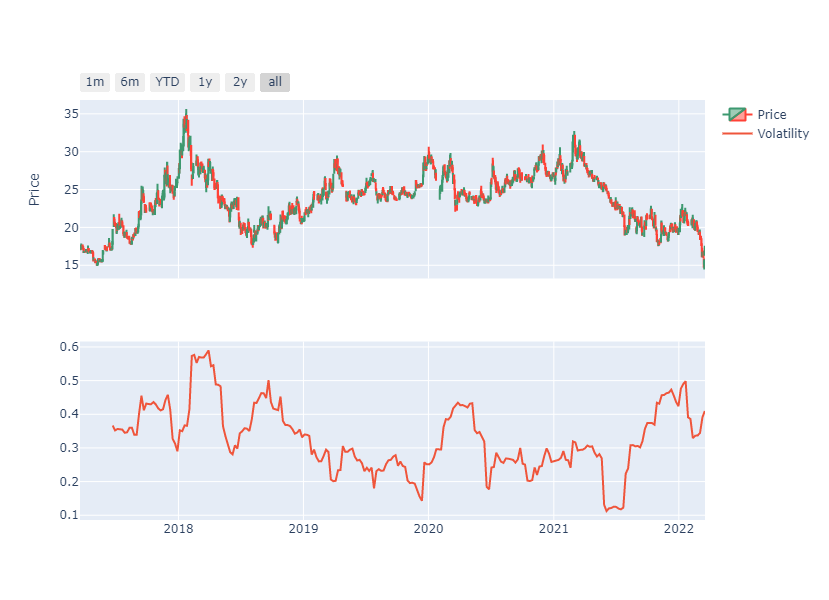

In [114]:
# stk='000002.SZ'
# from plotly.subplots import make_subplots

# fig_t=make_subplots(rows=2, cols=1, shared_xaxes=True)#,specs=[[{"secondary_y": True}]])

# fig_t.add_trace(go.Candlestick(x=df_5y.index,
#                                 open=df_5y[('Open',stk)],
#                                 high=df_5y[('High',stk)],
#                                 low=df_5y[('Low',stk)],
#                                 close=df_5y[('Close',stk)], 
#                                xaxis='x', yaxis='y', visible=True, name='Price'),
#                row=1, col=1)

# fig_t.add_trace(go.Scatter(x=df_weekly_return_rolling_3m_volann.index,
#                            y=df_weekly_return_rolling_3m_volann[stk],
#                            yaxis='y2',
#                            name='Volatility'
#                           ),
#                 row=2,col=1
#                 )

# # Add range slider
# fig_t.update_layout(
#     xaxis=dict(
#         rangeselector=dict(
#             buttons=list([
#                 dict(count=1,
#                      label="1m",
#                      step="month",
#                      stepmode="backward"),
#                 dict(count=6,
#                      label="6m",
#                      step="month",
#                      stepmode="backward"),
#                 dict(count=1,
#                      label="YTD",
#                      step="year",
#                      stepmode="todate"),
#                 dict(count=1,
#                      label="1y",
#                      step="year",
#                      stepmode="backward"),
#                 dict(count=2,
#                      label="2y",
#                      step="year",
#                      stepmode="backward"),
#                 dict(step="all")
#             ])
#         ),
#         rangeslider=dict(
#             visible=False
#         ),
#         type="date"
#     ),
#     yaxis=dict(
#         anchor='x',
#         autorange=True,
#         side='left',
#         title='Price'
#         ),
#     yaxis2=dict(
#         anchor='x',
#         autorange=True,
#         side='left'),
#     width=800, height=600
# )

# fig_t

# Archive

In [74]:
# app.run_server(mode='inline', debug=True)

In [75]:
mean_var

,index,mean_return,ann_vol,shortName,hover_name
0,000001.SZ,-0.001124,0.387906,PING AN BANK,000001.SZ PING AN BANK
1,000002.SZ,-0.004742,0.313579,CHINA VANKE CO,000002.SZ CHINA VANKE CO
2,000063.SZ,-0.006494,0.361133,ZTE CORP,000063.SZ ZTE CORP
3,000066.SZ,-0.001259,0.445663,CHINA GREATWALL TE,000066.SZ CHINA GREATWALL TE
4,000069.SZ,0.000772,0.380972,SHENZHEN OVERSEAS,000069.SZ SHENZHEN OVERSEAS
...,...,...,...,...,...
295,688363.SS,0.003119,0.498985,BLOOMAGE BIOTECHNOLOGY CORPORAT,688363.SS BLOOMAGE BIOTECHNOLOGY CORPORAT
296,688396.SS,0.002168,0.553507,CHINA RESOURCES MICROELECTRONIC,688396.SS CHINA RESOURCES MICROELECTRONIC
297,688561.SS,-0.006625,0.413594,QI AN XIN TECHNOLOGY GROUP INC,688561.SS QI AN XIN TECHNOLOGY GROUP INC
298,688599.SS,0.014985,0.568107,TRINA SOLAR CO LTD,688599.SS TRINA SOLAR CO LTD


In [111]:
mean_var[mean_var['index'].str.contains('603392')]

,index,mean_return,ann_vol,shortName,hover_name
273,603392.SS,0.031252,0.898584,BEIJING WANTAI BIOLOGICAL PHARM,603392.SS BEIJING WANTAI BIOLOGICAL PHARM


In [125]:
fig_mean_var.show('json')

In [204]:
import plotly.graph_objects as go

output=['603392.SS BEIJING WANTAI BIOLOGICAL PHARM', '000001.SZ PING AN BANK']
        
# filtered_df = mean_var.loc[mean_var['index'].isin(output), :]
filtered_df = mean_var

fig_mean_var = px.scatter(mean_var.loc[~mean_var.hover_name.isin(output)], x="mean_return", y="ann_vol", hover_name="hover_name", 
         # color="", hover_name="", size=5,
         log_x=False, size_max=60)

fig_mean_var = go.Figure(fig_mean_var)
fig_mean_var.add_trace(go.Scatter(
                            x=mean_var.loc[mean_var.hover_name.isin(output),'mean_return'],
                            y=mean_var.loc[mean_var.hover_name.isin(output),'ann_vol'],
                            name='',
                            showlegend = False,
                            hovertemplate= "<b>%{hovertext}</b><br><br>mean_return=%{x}<br>ann_vol=%{y}<extra></extra>",
                            hovertext=mean_var.loc[mean_var.hover_name.isin(output),'hover_name'],
                            marker=dict(
                                color='red',
                                symbol='circle'
                            ),
                            mode='markers'
                           )
                            
                            
                      )                        


# on_hover
for sel_stock in ['603392.SS']:

    fig_mean_var.add_trace(dict(
                                mode="markers",
                                x= list(df_weekly_return_rolling_1y_mean.loc[:, sel_stock]),
                                y= list(df_weekly_return_rolling_1y_volann.loc[:, sel_stock]),
                                text= list(df_weekly_return_rolling_1y_mean.index),
                                name=sel_stock,
                                showlegend=False,
                                hovertemplate= "<b>" + sel_stock+ "<br>%{hovertext}</b><br><br>mean_return=%{x}<br>ann_vol=%{y}<extra></extra>",
                                hovertext=list(df_weekly_return_rolling_1y_mean.index),
                                line=dict(
                                    color='red',
                                    dash='solid',
                                    
                                ),
                                marker=dict(
                                    symbol='circle',
                                    color=_continuous_scale='YlOrRd'
                                    # opacity=np.linspace(0,1,len(df_weekly_return_rolling_1y_mean.index))
                                ),
                                textposition='bottom right',

                               )
                          )

fig_mean_var.update_xaxes(label='1y Rolling Mean Weekly Return', tickformat='.2%')
fig_mean_var.update_yaxes(label='1y Rolling Weekly Return Stdev', tickformat='.2%')

fig_mean_var.show()

AttributeError: 'DataFrame' object has no attribute 'hover_name'

In [80]:
# Run this app with `python app.py` and
# visit http://127.0.0.1:8050/ in your web browser.

from dash import Dash, html, dcc, Input, Output
import plotly.graph_objects as go


app = JupyterDash(__name__)

# mean_var
t = '2022-03-08'
mean_var = pkl.load(open('./data/mean_var_{}.pkl'.format(t), 'rb'))
# get the names of stocks
t_1 = '20220301'
df_info_raw = pkl.load(open('./data/df_info_raw_{}.pkl'.format(t_1), 'rb'))
mean_var = mean_var.merge(df_info_raw.loc['shortName'], left_index=True, right_index=True, how='left').reset_index()
mean_var['hover_name'] = mean_var[['index', 'shortName']].agg(' '.join, axis=1)

stock_names = ['{} {}'.format(ticker, name) for ticker, name in list(df_info_raw.loc['shortName', :].iteritems())]

app.layout = html.Div([
    html.Div(children=[
        html.Label('Multi-Select Dropdown'),
        dcc.Dropdown(stock_names,
                     [''],
                     multi=True, id='my-input'),
        html.Br(),
        dcc.Graph(id='graph-scatter')
        
    ], style={'padding': 10, 'flex': 1}),    
], style={'display': 'flex', 'flex-direction': 'row'})


@app.callback(
    Output(component_id='graph-scatter', component_property='figure'),
    Input(component_id='my-input', component_property='value')
)
def update_figure(stocks):
    
    # filtered_df = mean_var.loc[mean_var['index'].isin(output), :]
    fig_mean_var = px.scatter(mean_var.loc[~mean_var.hover_name.isin(stocks)], x="mean_return", y="ann_vol", hover_name="hover_name", 
     # color="", hover_name="", size=5,
     log_x=False, size_max=60)

    fig_mean_var = go.Figure(fig_mean_var)
#     fig_mean_var.add_trace(dict(type='scatter',
#                                 x=mean_var.loc[mean_var.hover_name.isin(stocks),'mean_return'],
#                                 y=mean_var.loc[mean_var.hover_name.isin(stocks),'ann_vol'],
#                                 name='',
#                                 showlegend = False,
#                                 hovertemplate= "<b>%{hovertext}</b><br><br>mean_return=%{x}<br>ann_vol=%{y}<extra></extra>",
#                                 hovertext=mean_var.loc[mean_var.hover_name.isin(stocks),'hover_name'],
#                                 marker=dict(
#                                     color='red',
#                                     symbol='circle'
#                                 ),
#                                 mode='markers'
#                                )


#                           )
    
    ## add the historical trend of mean/var
    
    
    fig_mean_var.add_trace(dict(
                                mode="lines+text+markers",
                                x=df_weekly_return_rolling_1y_mean.loc[:, df_weekly_return_rolling_1y_mean.columns.isin(['603392.SS'])],
                                y=df_weekly_return_rolling_1y_volann.loc[:, df_weekly_return_rolling_1y_volann.columns.isin(['603392.SS'])],
                                text=df_weekly_return_rolling_1y_mean.index,
                                name='',
                                showlegend=False,
                                hovertemplate= "<b>%{hovertext}</b><br><br>mean_return=%{x}<br>ann_vol=%{y}<extra></extra>",
                                hovertext='',
                                line=dict(
                                    color='red',
                                    dash='solid'
                                ),
                                marker=dict(
                                    symbol='circle'
                                ),
                                
                                    
                               )
                          )

                           
    
    ## Update
    fig_mean_var.update_xaxes(label='1y Rolling Mean Weekly Return', tickformat='.2%')
    fig_mean_var.update_yaxes(label='1y Rolling Weekly Return Stdev', tickformat='.2%')
    fig_mean_var.update_layout(transition_duration=0)
    
    # fig_mean_var.update_traces(selector=dict(type='scatter'))
                               
    return fig_mean_var

app.run_server('jupyterlab')

C:\Users\user\.conda\envs\capstone\lib\site-packages\jupyter_dash\jupyter_app.py:139: UserWarning:

The 'environ['werkzeug.server.shutdown']' function is deprecated and will be removed in Werkzeug 2.1.



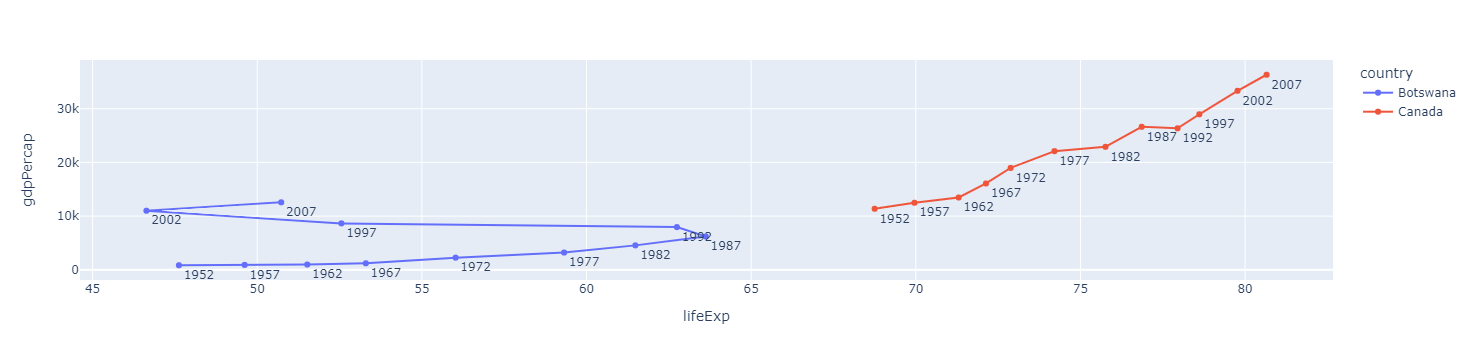

In [81]:
import plotly.express as px

df = px.data.gapminder().query("country in ['Canada', 'Botswana']")

fig = px.line(df, x="lifeExp", y="gdpPercap", color="country", text="year")
fig.update_traces(textposition="bottom right")
fig.show('json')
fig.show()

In [249]:
df_weekly_return_rolling_1y_mean.loc[:, df_weekly_return_rolling_1y_mean.columns.isin(['603392.SS'])]


,603392.SS
Date,
2021-03-26,0.055535
2021-04-02,0.056460
2021-04-09,0.058510
2021-04-16,0.058717
2021-04-23,0.059952
2021-04-30,0.059645
2021-05-07,0.053020
2021-05-14,0.045988
2021-05-21,0.036591


In [227]:
df_weekly_return_rolling_1y_volann.loc[:, df_weekly_return_rolling_1y_volann.columns.isin(['603392.SS'])]

,603392.SS
Date,
2021-03-26,1.153670
2021-04-02,1.152311
2021-04-09,1.151918
2021-04-16,1.151411
2021-04-23,1.149862
2021-04-30,1.150821
2021-05-07,1.132973
2021-05-14,1.049534
2021-05-21,0.954602


In [223]:
df_weekly_return_rolling_1y_mean.index

DatetimeIndex(['2021-03-26', '2021-04-02', '2021-04-09', '2021-04-16',
               '2021-04-23', '2021-04-30', '2021-05-07', '2021-05-14',
               '2021-05-21', '2021-05-28', '2021-06-04', '2021-06-11',
               '2021-06-18', '2021-06-25', '2021-07-02', '2021-07-09',
               '2021-07-16', '2021-07-23', '2021-07-30', '2021-08-06',
               '2021-08-13', '2021-08-20', '2021-08-27', '2021-09-03',
               '2021-09-10', '2021-09-17', '2021-09-24', '2021-10-01',
               '2021-10-08', '2021-10-15', '2021-10-22', '2021-10-29',
               '2021-11-05', '2021-11-12', '2021-11-19', '2021-11-26',
               '2021-12-03', '2021-12-10', '2021-12-17', '2021-12-24',
               '2021-12-31', '2022-01-07', '2022-01-14', '2022-01-21',
               '2022-01-28', '2022-02-04', '2022-02-11', '2022-02-18',
               '2022-02-25', '2022-03-04', '2022-03-11', '2022-03-18'],
              dtype='datetime64[ns]', name='Date', freq='W-FRI')

## Animation

In [214]:
import plotly.express as px
df = px.data.gapminder()
fig_ani = px.scatter(df, x="gdpPercap", y="lifeExp", animation_frame="year", animation_group="country",
           size="pop", color="continent", hover_name="country",
           log_x=True, size_max=55, range_x=[100,100000], range_y=[25,90])

In [215]:
# fig_ani.show()

In [216]:
# fig_ani.update_xaxes(tickformat='.2%')

In [ ]:
import plotly.express as px
df = px.data.gapminder().query("year == 2007").sort_values(by="lifeExp")
fig = px.bar(df, y="continent", x="pop", color="lifeExp", orientation="h",
             color_continuous_scale='Bluered_r', hover_name="country")

fig.show()

## Color scale

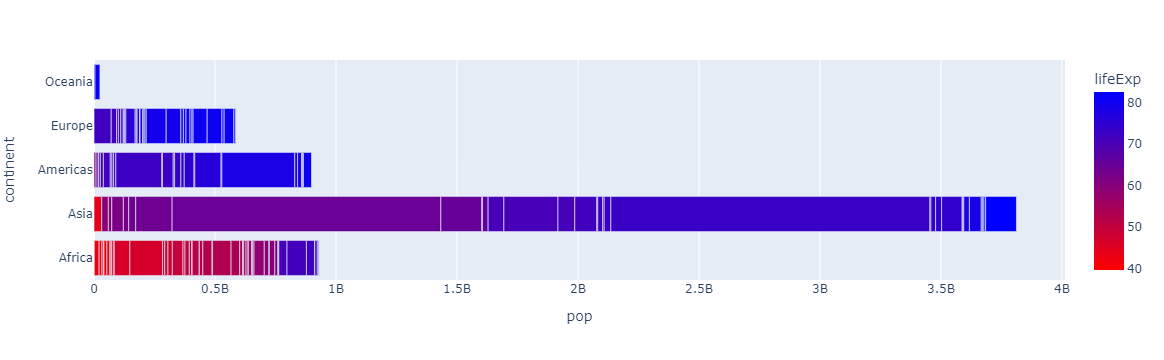

In [217]:

import plotly.express as px
df = px.data.gapminder().query("year == 2007").sort_values(by="lifeExp")
fig = px.bar(df, y="continent", x="pop", color="lifeExp", orientation="h",
             color_continuous_scale='Bluered_r', hover_name="country")

fig.show()

In [218]:
fig.show('json')

In [221]:
px.colors.sequential.YlOrRd

['rgb(255,255,204)',
 'rgb(255,237,160)',
 'rgb(254,217,118)',
 'rgb(254,178,76)',
 'rgb(253,141,60)',
 'rgb(252,78,42)',
 'rgb(227,26,28)',
 'rgb(189,0,38)',
 'rgb(128,0,38)']